# Assignment #4

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import trange, tqdm

torch.__version__

'1.2.0'

In [2]:
transform = transforms.Compose([#transforms.Resize((1,10000)),
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '..\\Assignment#2\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# print(trainset)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = '..\\Assignment#2\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

In [3]:
train_data = np.zeros((10000, 0))
train_label = np.zeros((0,1))
val_data = np.zeros((10000,0))
val_label = np.zeros((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    train_label = np.append(train_label, labels)

train_label = train_label.reshape(1,1027)


# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data

    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    val_data = np.hstack((val_data, np.reshape(inputs, (10000,1))))

    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    val_label = np.append(val_label, labels)

val_label = val_label.reshape(1,256)


print("train_label shape : " + str(train_label.shape))
print("train_data shape  : " + str(train_data.shape))
print("val_label shape   : " + str(val_label.shape))
print("val_label shape   : " + str(val_data.shape))

train_label shape : (1, 1027)
train_data shape  : (10000, 1027)
val_label shape   : (1, 256)
val_label shape   : (10000, 256)


In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def ReLU(z):
    return np.maximum(0, z)

def LeakyReLU(z, a):
    return np.maximum(a*z, z)

def countCorrect(hyphothesis, label, std):
    cnt = 0
    for i, x in enumerate(hyphothesis):
        if x >= std:          
            if label[0][i] == 1 :
                cnt+=1
        else :
            if label[0][i] == 0 :
                cnt+=1
    
    return cnt

### $ g^{[1]}, g^{[2]}, g^{[3]} $ are Sigmoid (from the previous assignment)

In [5]:
# INITIALIZE VARIABLES, EPOCH, LEARNING RATE, NUMBER OF NODES IN HIDDEN LAYER
NUM_EPOCH = 25000
NUM_HIDDEN_LAYER_1 = 5
NUM_HIDDEN_LAYER_2 = 3
LEARNING_RATE_1 = 0.05
EPSILON = 0.00000000001

NUM_TRAIN_DATA = train_data.shape[1]
NUM_VAL_DATA = val_data.shape[1]
IMAGE_VECTOR_LEN = train_data.shape[0]

w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

sig_train_loss = []
sig_train_accuracy = []
sig_val_loss = []
sig_val_accuracy = []

In [6]:
prev_loss = 0
loss = 0

for i in trange(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) *  (1 - A_2) * A_2
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * (1 - A_1) * A_1
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE_1 * dw_1
    w_2 = w_2 - LEARNING_RATE_1 * dw_2
    w_3 = w_3 - LEARNING_RATE_1 * dw_3
    
    b_1 = b_1 - LEARNING_RATE_1 * db_1
    b_2 = b_2 - LEARNING_RATE_1 * db_2
    b_3 = b_3 - LEARNING_RATE_1 * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    sig_train_loss.append(J)
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
        for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
            
    sig_train_accuracy.append(correct / NUM_TRAIN_DATA)
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    sig_val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
            
    sig_val_accuracy.append(correct / NUM_VAL_DATA)
    
#     if abs(loss - prev_loss) < EPSILON :
#         print("Train loss converged at Epoch " + str(i+1))
#         break
#     prev_loss = loss 

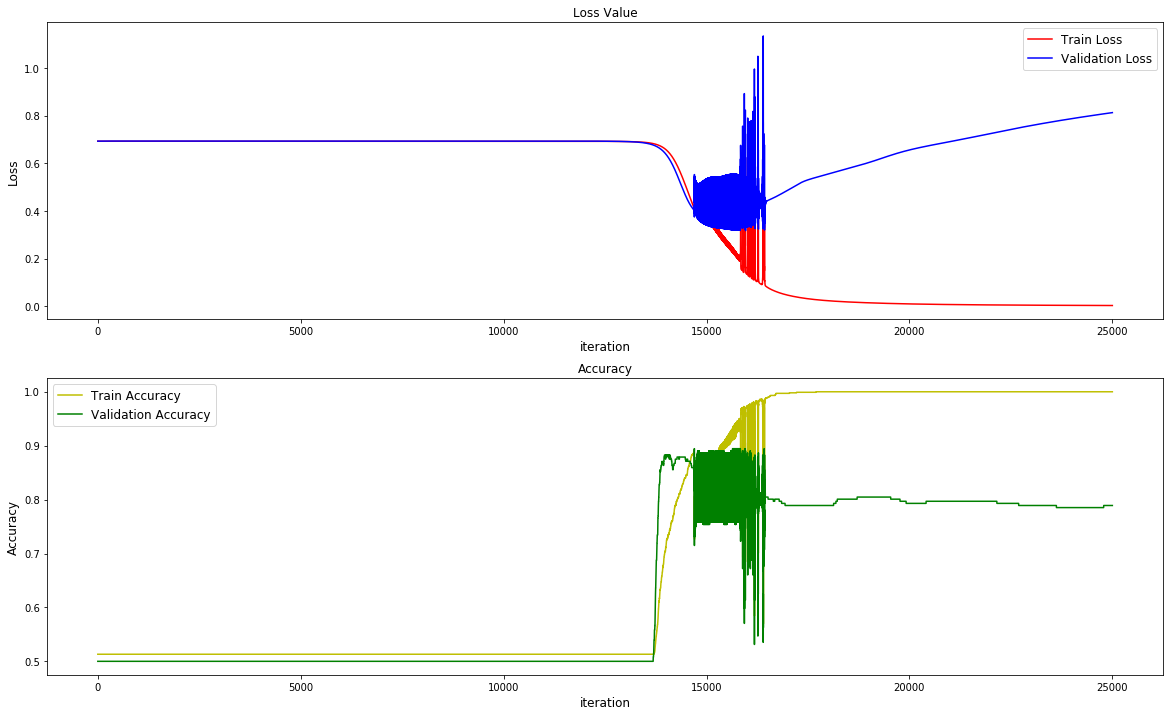

In [7]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(sig_train_loss)+1), sig_train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(sig_val_loss)+1), sig_val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(sig_train_accuracy)+1), sig_train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(sig_val_accuracy)+1), sig_val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

In [8]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
sig_best_acc = max(sig_val_accuracy)
sig_index = sig_val_accuracy.index(sig_best_acc)

### Result when  $ g^{[1]}, g^{[2]}, g^{[3]} $ are Sigmoid (from the previous assignment)

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| {{ round(sig_train_loss[sig_index], 5) }} | {{ round(sig_train_accuracy[sig_index],5) }}|
|Validation| {{ round(sig_val_loss[sig_index],5) }} | {{ round(sig_best_acc,5) }} |

### $ g^{[1]}, g^{[2]} $ are tanh and $ g^{[3]} $ is Sigmoid

In [9]:
LEARNING_RATE_2 = 0.01

w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

tanh_train_loss = []
tanh_train_accuracy = []
tanh_val_loss = []
tanh_val_accuracy = []

In [10]:
prev_loss = 0
loss = 0

for i in trange(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = tanh(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = tanh(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) *(1 - A_2) * (1 + A_2)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * (1 - A_1) * (1 + A_1)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE_2 * dw_1
    w_2 = w_2 - LEARNING_RATE_2 * dw_2
    w_3 = w_3 - LEARNING_RATE_2 * dw_3
    
    b_1 = b_1 - LEARNING_RATE_2 * db_1
    b_2 = b_2 - LEARNING_RATE_2 * db_2
    b_3 = b_3 - LEARNING_RATE_2 * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    tanh_train_loss.append(J)
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    tanh_train_accuracy.append(correct / NUM_TRAIN_DATA)
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = tanh(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = tanh(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    tanh_val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    tanh_val_accuracy.append(correct / NUM_VAL_DATA)
    
#     if abs(loss - prev_loss) < EPSILON :
#         print("Train loss converged at Epoch " + str(i+1))
#         break
#     prev_loss = loss 

In [11]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
tanh_best_acc = max(tanh_val_accuracy)
tanh_index = tanh_val_accuracy.index(tanh_best_acc)

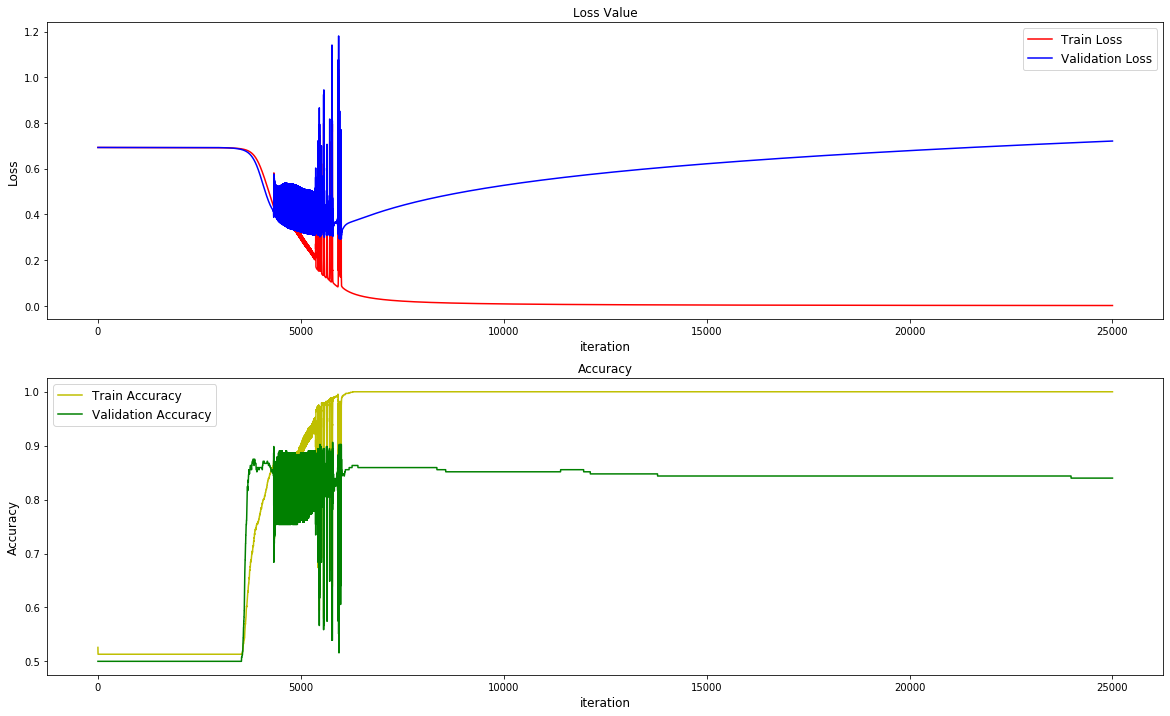

In [12]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(tanh_train_loss)+1), tanh_train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(tanh_val_loss)+1), tanh_val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(tanh_train_accuracy)+1), tanh_train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(tanh_val_accuracy)+1), tanh_val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when $ g^{[1]}, g^{[2]} $ are tanh and $ g^{[3]} $ is Sigmoid

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| {{ round(tanh_train_loss[tanh_index],5) }} | {{  round(tanh_train_accuracy[tanh_index],5) }}|
|Validation| {{ round(tanh_val_loss[tanh_index],5) }} | {{ round(tanh_best_acc,5) }} |

## $ g^{[1]}, g^{[2]} $ are ReLU and $ g^{[3]} $ is Sigmoid

In [33]:
LEARNING_RATE_3 = 0.0001

w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

relu_train_loss = []
relu_train_accuracy = []
relu_val_loss = []
relu_val_accuracy = []

In [34]:
prev_loss = 0
loss = 0

for i in trange(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = ReLU(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = ReLU(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = (np.dot(w_3.T, dz_3) > 0).astype(int)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = (np.dot(w_2.T, dz_2) > 0).astype(int)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE_3 * dw_1
    w_2 = w_2 - LEARNING_RATE_3 * dw_2
    w_3 = w_3 - LEARNING_RATE_3 * dw_3
    
    b_1 = b_1 - LEARNING_RATE_3 * db_1
    b_2 = b_2 - LEARNING_RATE_3 * db_2
    b_3 = b_3 - LEARNING_RATE_3 * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    relu_train_loss.append(J)
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    relu_train_accuracy.append(correct / NUM_TRAIN_DATA)
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = ReLU(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = ReLU(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    relu_val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    relu_val_accuracy.append(correct / NUM_VAL_DATA)
    
#     if abs(loss - prev_loss) < EPSILON * 0.000000001 :
#         print("Train loss converged at Epoch " + str(i+1))
#         break
#     prev_loss = loss 

In [35]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
relu_best_acc = max(relu_val_accuracy)
relu_index = relu_val_accuracy.index(relu_best_acc)

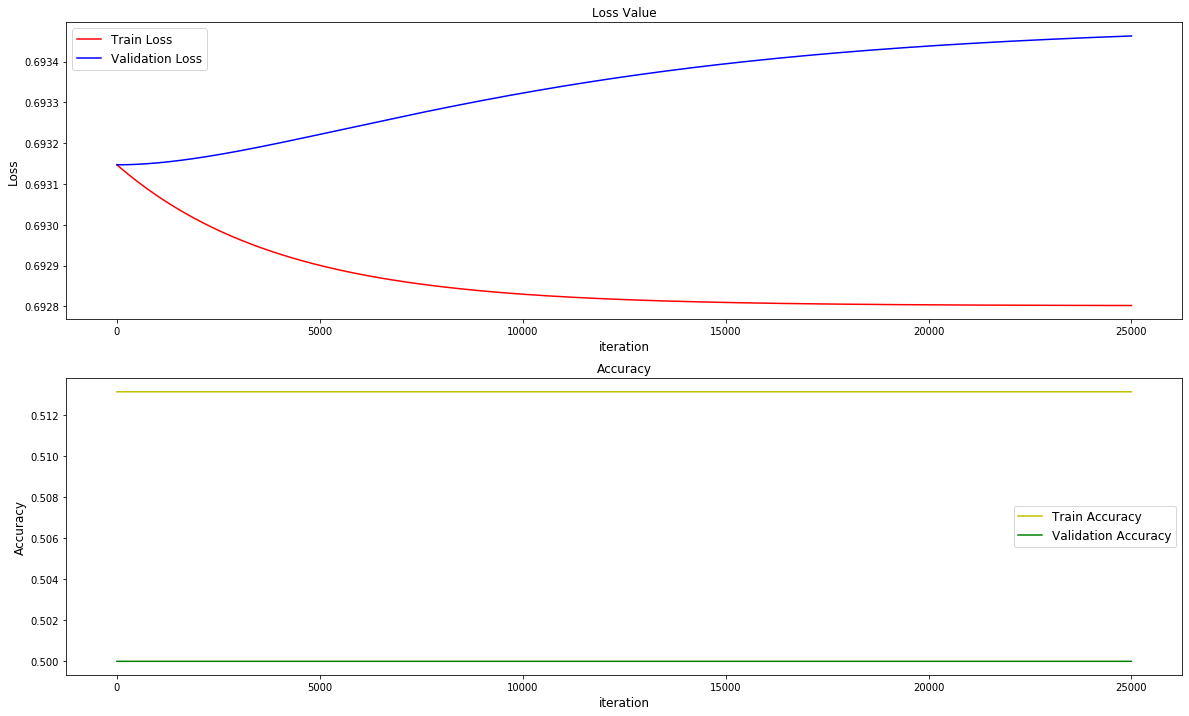

In [32]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(relu_train_loss)+1), relu_train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(relu_val_loss)+1), relu_val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(relu_train_accuracy)+1), relu_train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(relu_val_accuracy)+1), relu_val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when $ g^{[1]}, g^{[2]} $ are ReLU and $ g^{[3]} $ is Sigmoid

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| {{ round(relu_train_loss[relu_index],5) }} | {{  round(relu_train_accuracy[relu_index],5) }}|
|Validation| {{ round(relu_val_loss[relu_index],5) }} | {{ relu_best_acc }} |

## $ g^{[1]}, g^{[2]} $ are Leaky ReLU with your choice of $ \alpha $ and $ g^{[3]} $ is Sigmoid

In [36]:
LEARNING_RATE_4 = 0.00005
ALPHA = 0.01

w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

leaky_train_loss = []
leaky_train_accuracy = []
leaky_val_loss = []
leaky_val_accuracy = []

In [37]:
prev_loss = 0
loss = 0

for i in trange(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = LeakyReLU(z_1, ALPHA)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = LeakyReLU(z_2, ALPHA)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3)
    dz_2[dz_2 > 0] = 1
    dz_2[dz_2 <= 0] = ALPHA
    
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2)
    dz_1[dz_1 > 0] = 1
    dz_1[dz_1 <= 0] = ALPHA
    
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE_4 * dw_1
    w_2 = w_2 - LEARNING_RATE_4 * dw_2
    w_3 = w_3 - LEARNING_RATE_4 * dw_3
    
    b_1 = b_1 - LEARNING_RATE_4 * db_1
    b_2 = b_2 - LEARNING_RATE_4 * db_2
    b_3 = b_3 - LEARNING_RATE_4 * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    leaky_train_loss.append(J)
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    leaky_train_accuracy.append(correct / NUM_TRAIN_DATA)
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = LeakyReLU(z_1, ALPHA)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = LeakyReLU(z_2, ALPHA)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    leaky_val_loss.append(J)
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    leaky_val_accuracy.append(correct / NUM_VAL_DATA)
    
#     if abs(loss - prev_loss) < EPSILON :
#         print("Train loss converged at Epoch " + str(i+1))
#         break
#     prev_loss = loss 

In [38]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
leaky_best_acc = max(leaky_val_accuracy)
leaky_index = leaky_val_accuracy.index(leaky_best_acc)

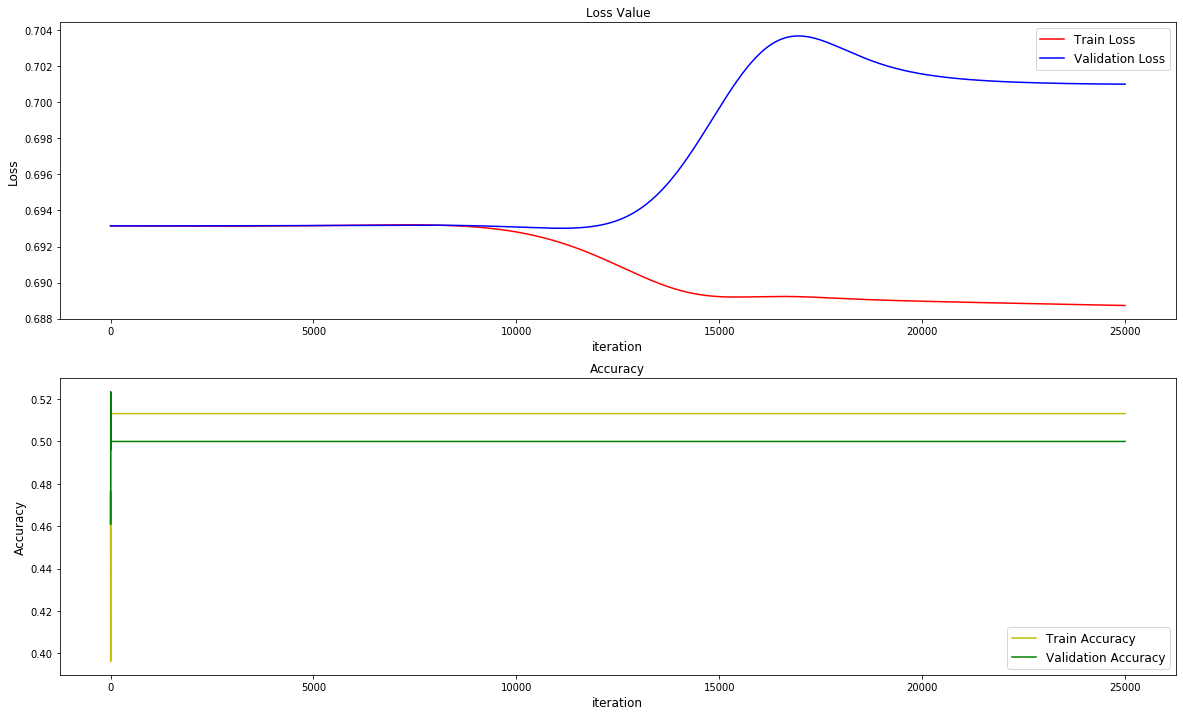

In [39]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(range(1, len(leaky_train_loss)+1), leaky_train_loss,'-r', label='Train Loss')
ax2[0].plot(range(1, len(leaky_val_loss)+1), leaky_val_loss, '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(range(1, len(leaky_train_accuracy)+1), leaky_train_accuracy, '-y', label='Train Accuracy')
ax2[1].plot(range(1, len(leaky_val_accuracy)+1), leaky_val_accuracy, '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when $ g^{[1]}, g^{[2]} $ are Leaky ReLU with your choice of $ \alpha $ and $ g^{[3]} $ is Sigmoid

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| {{ round(leaky_train_loss[leaky_index],5) }} | {{ round(leaky_train_accuracy[leaky_index],5) }} |
|Validation| {{ round(leaky_val_loss[leaky_index],5) }} | {{ round(leaky_best_acc,5) }} |